### Visualizing the distribution of the observations

### Load the required libraries

In [94]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext,SparkConf
sc.stop()
conf = SparkConf()
conf = conf.setAppName("temp1")
conf = conf.setMaster("local")
conf = conf.set("spark.driver.host", "localhost")
sc = SparkContext(conf=conf, master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])
#sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/Users/Weijian/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12836
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    13|[B0 58 A0 57 28 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    14|[10 5A 08 59 30 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    46|[E8 59 40 5A 38 5...|1972.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    18|[A0 56 B0 58 B0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    21|[E0 58 40 56 58 5...|1974.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [95]:
df.show(50)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    13|[B0 58 A0 57 28 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    14|[10 5A 08 59 30 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    46|[E8 59 40 5A 38 5...|1972.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    18|[A0 56 B0 58 B0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    21|[E0 58 40 56 58 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|     8|[28 58 A0 57 80 5...|1975.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    21|[F0 56 F0 56 80 5...|1976.0|SSSSSSBB|
|    433.1

### Select data for a particular station and measurement type

In [96]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00022462')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00022462'
33 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    383.1| 33.5833|-112.0833|       PRCP|USC00022462|    18|[00 7E 00 7E 00 7...|1950.0|SSSSSSBB|
|    383.1| 33.5833|-112.0833|       PRCP|USC00022462|     6|[00 00 00 00 00 0...|1951.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(33, 365)

### Script for plotting yearly plots

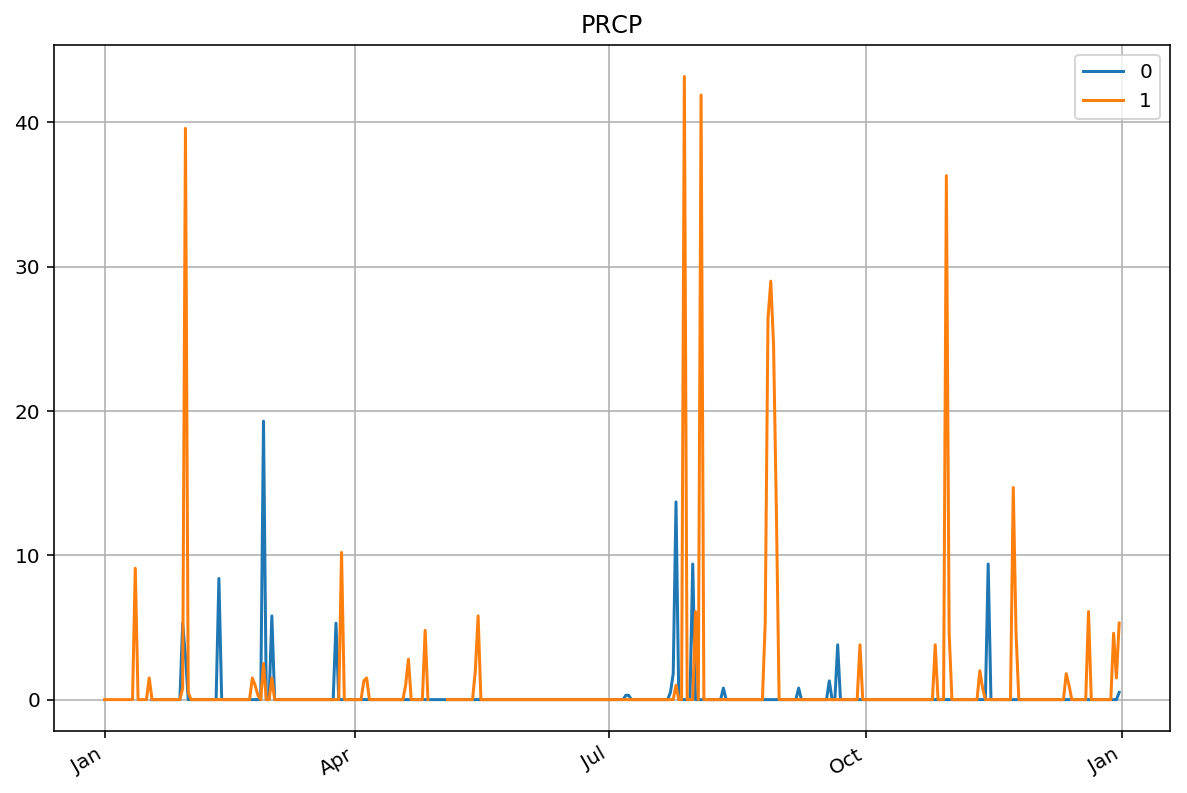

In [97]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [98]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

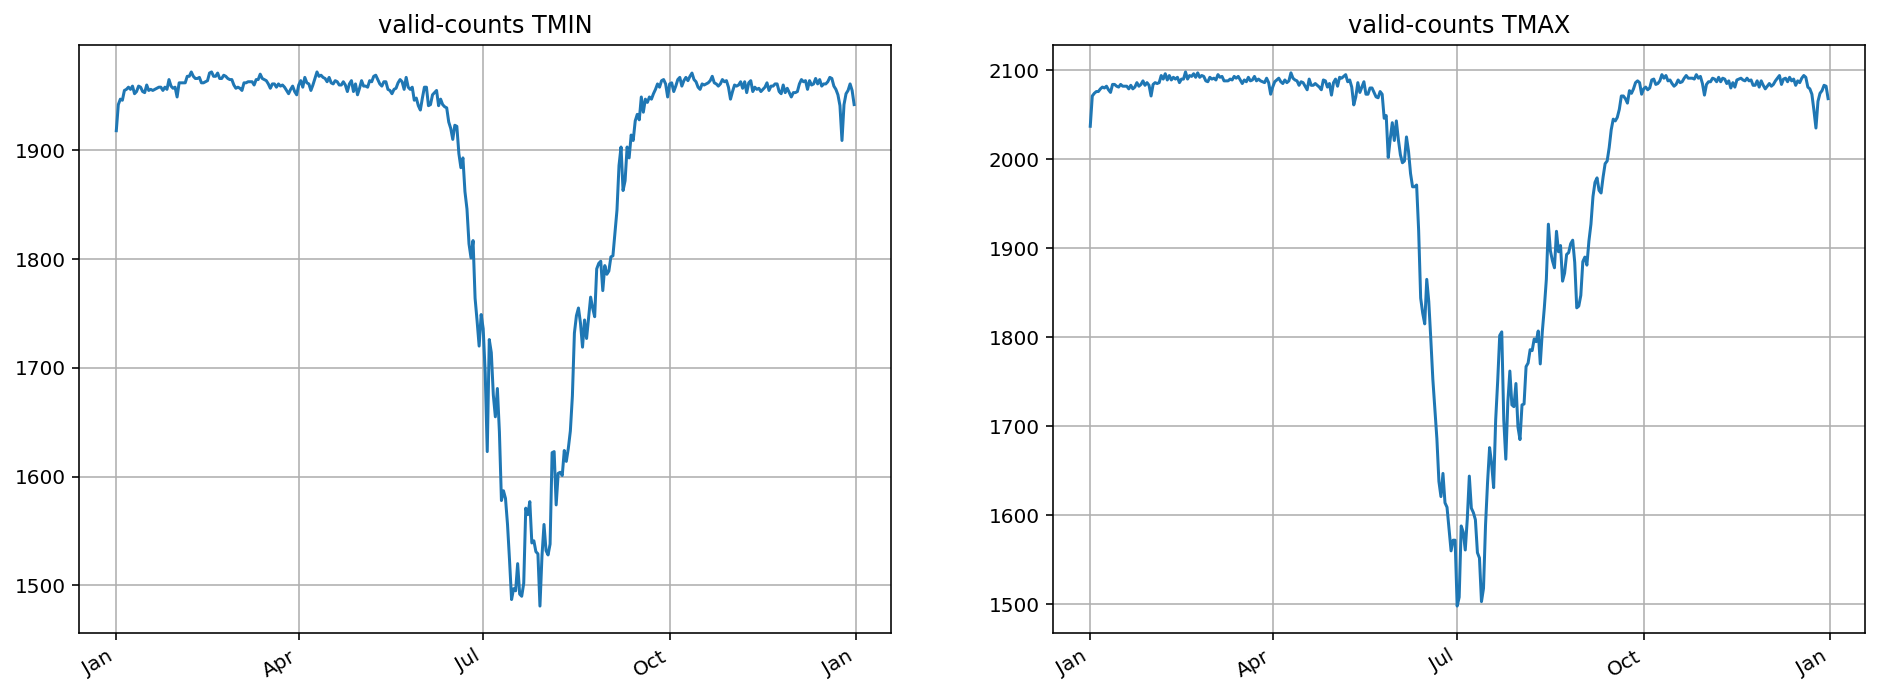

In [99]:
plot_pair(['TMIN','TMAX'],plot_valid)

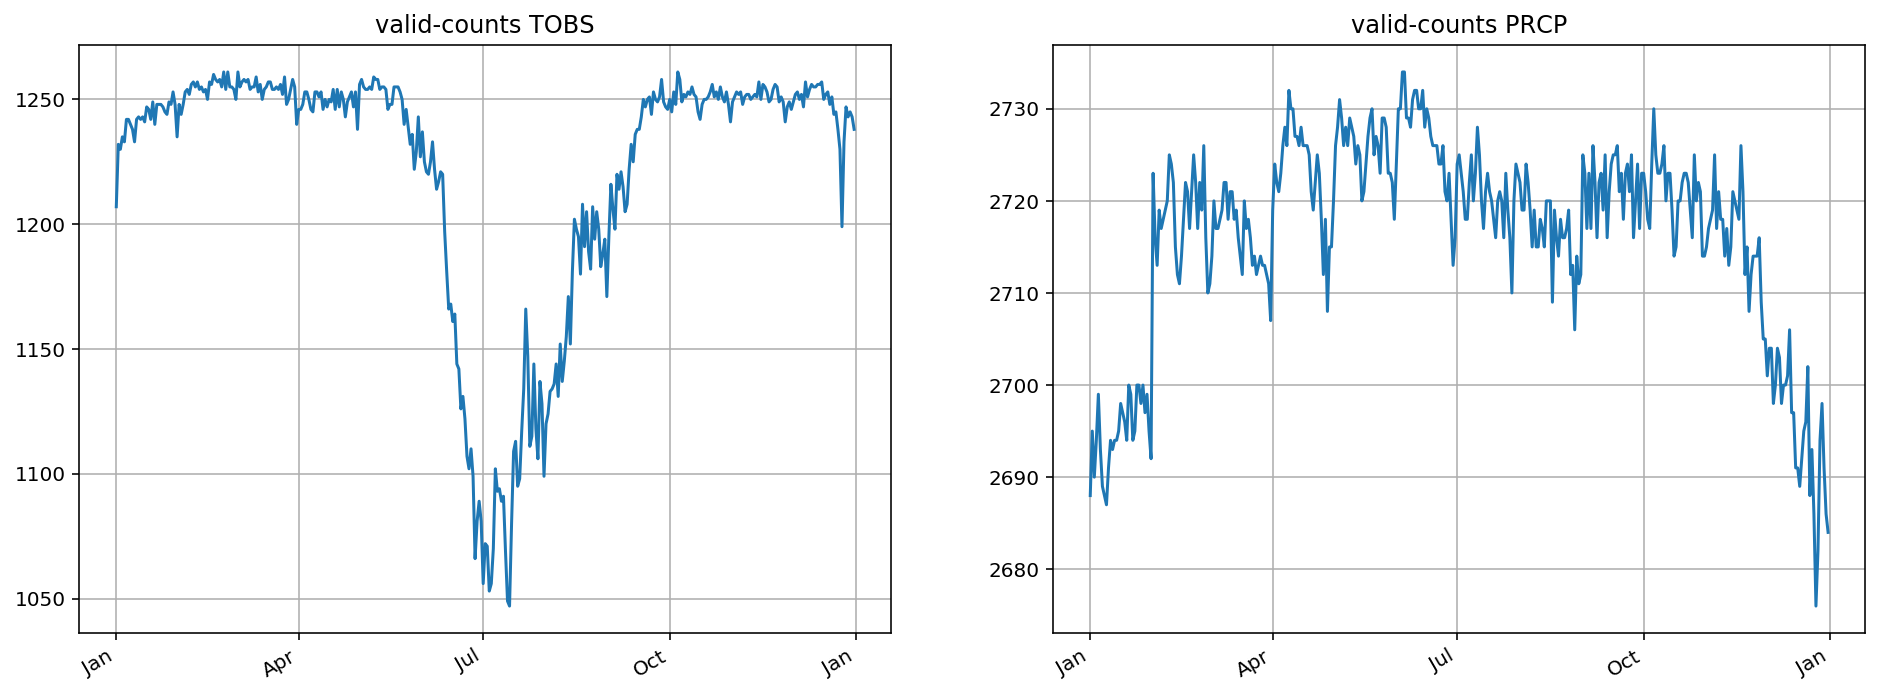

In [100]:
plot_pair(['TOBS','PRCP'],plot_valid)

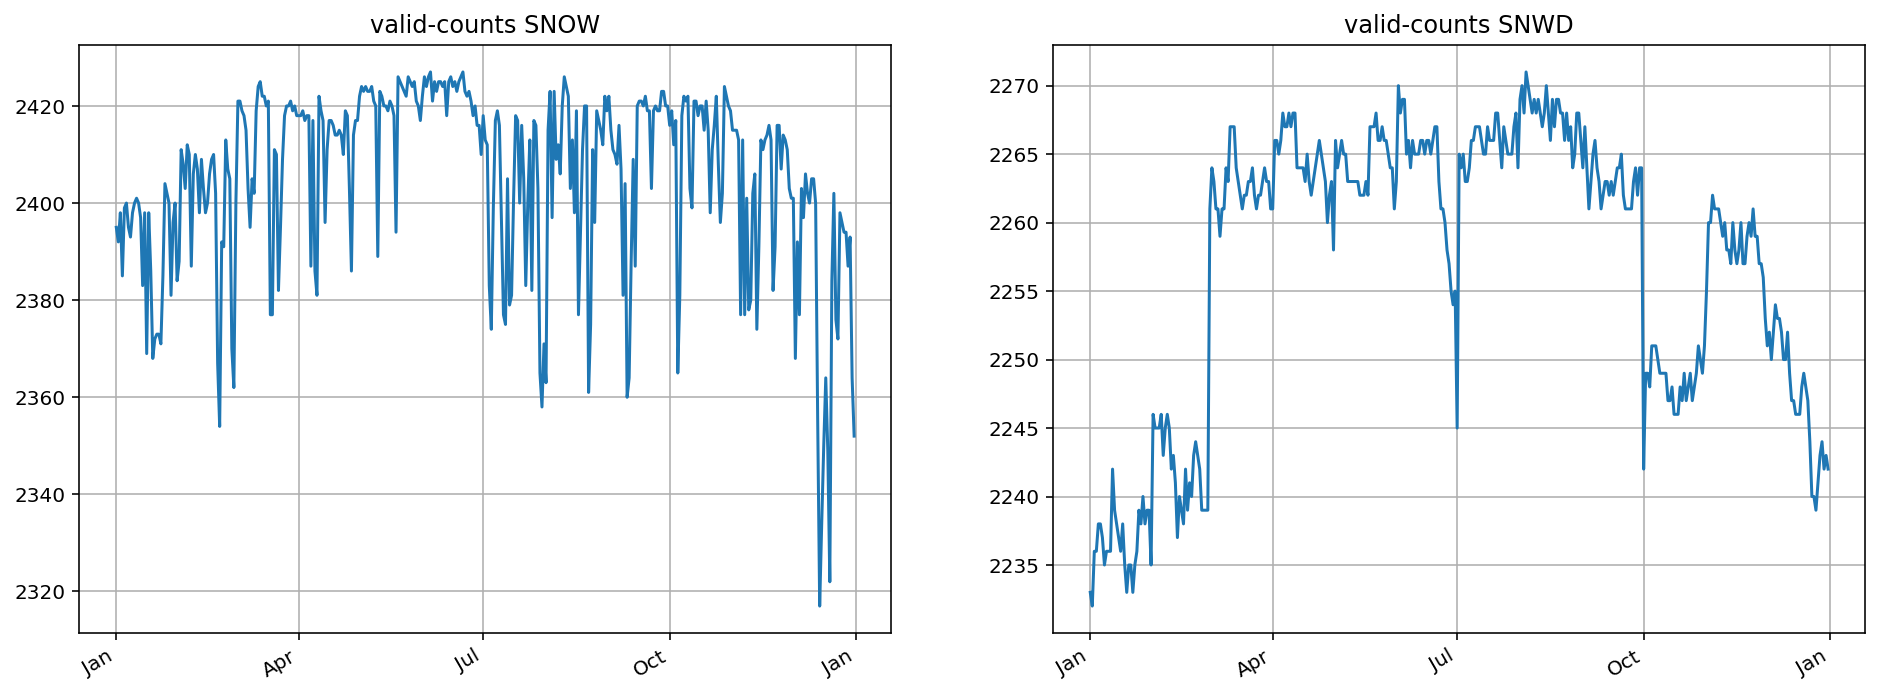

In [101]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [124]:
def plot_mean_std_tmin_tmax_tobs(m,fig,axis): # Use degree Celsius instead of tenths.
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    graphs = graphs / 10.0
    YP.plot(graphs,fig,axis,title='mean+/-std (degree Celsius)   '+m)

In [127]:
YP.plot?

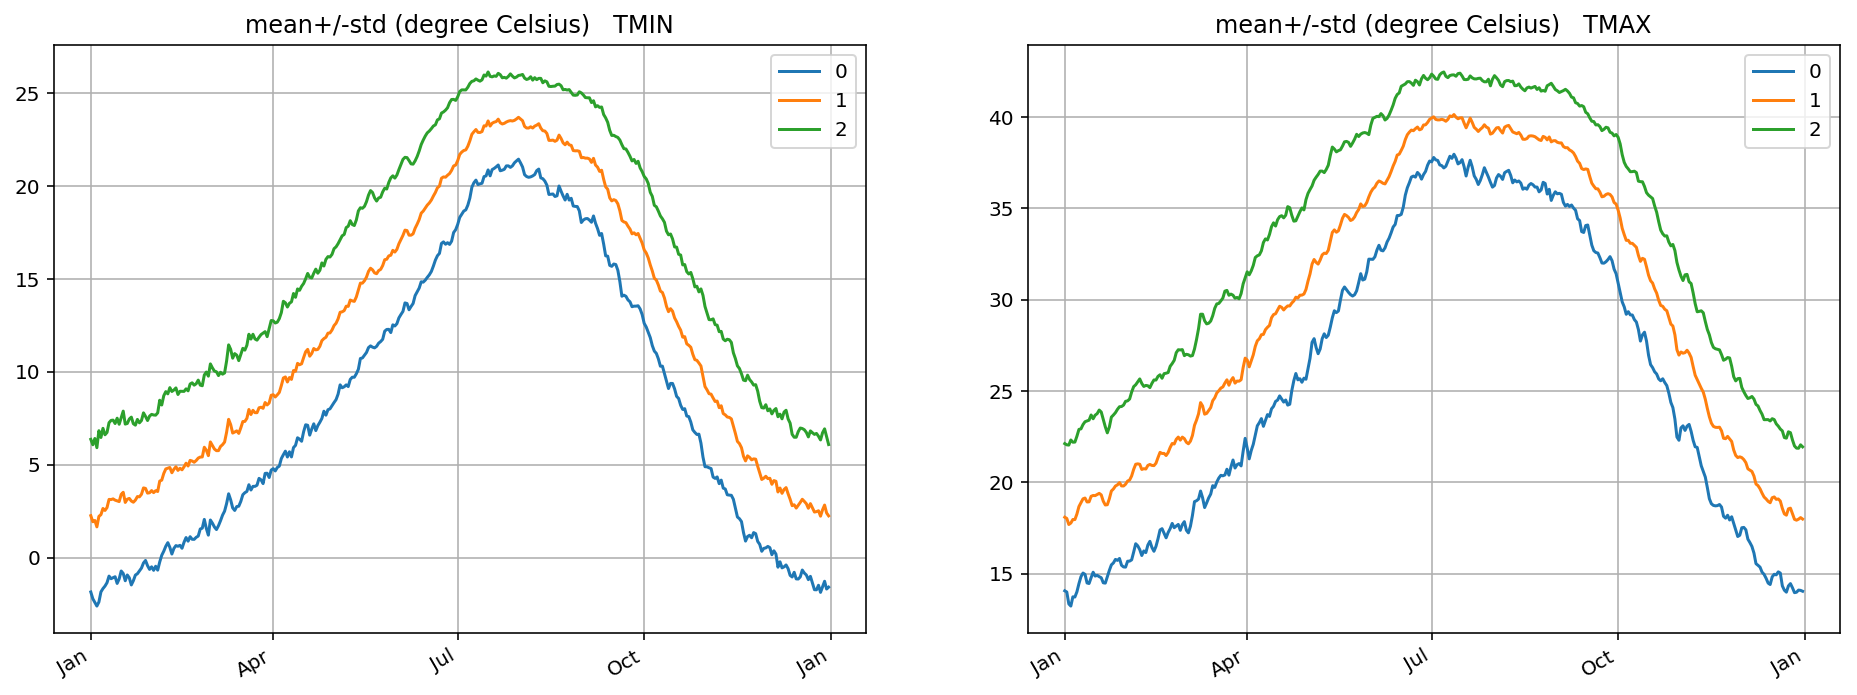

In [125]:
plot_pair(['TMIN','TMAX'],plot_mean_std_tmin_tmax_tobs)

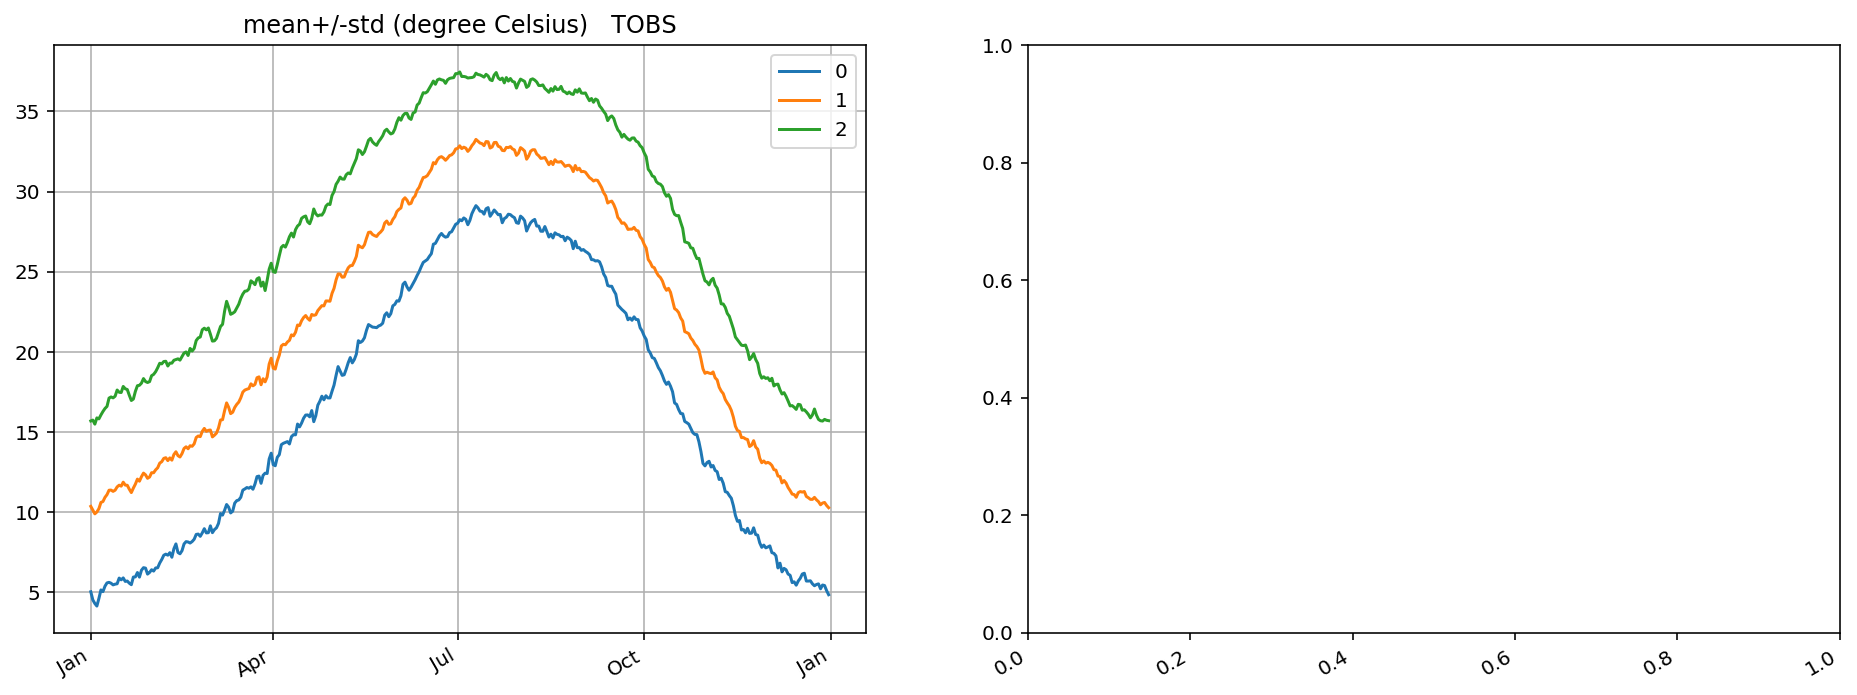

In [126]:
plot_pair(['TOBS'],plot_mean_std_tmin_tmax_tobs)

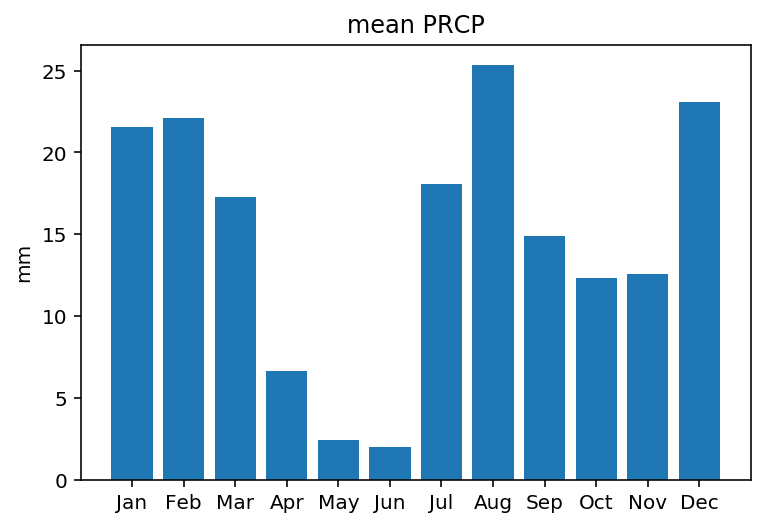

In [123]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pos = np.arange(len(months))

PRCP_mean=STAT['PRCP']['Mean']
PRCP_month = []
for i in range(12):
    PRCP_month.append(PRCP_mean[365*i/12:365*(i+1)/12].sum())
PRCP_month=np.array(PRCP_month) / 10.0
plt.bar(pos, PRCP_month)
#plt.plot(pos, [PRCP_month.mean()] * 12, color='C1')
plt.xticks(pos, months)
plt.ylabel('mm')
plt.title('mean PRCP')
plt.show()

In [105]:
PRCP_month

array([ 215.35833216,  221.06297417,  172.88920158,   66.08851146,
         23.96865731,   19.96570318,  180.49508464,  253.19830457,
        148.66592194,  123.27806788,  125.81840709,  231.04744081])

In [133]:
def plot_mean_std_snow_snwd(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='mean+/-std (mm)  '+m)

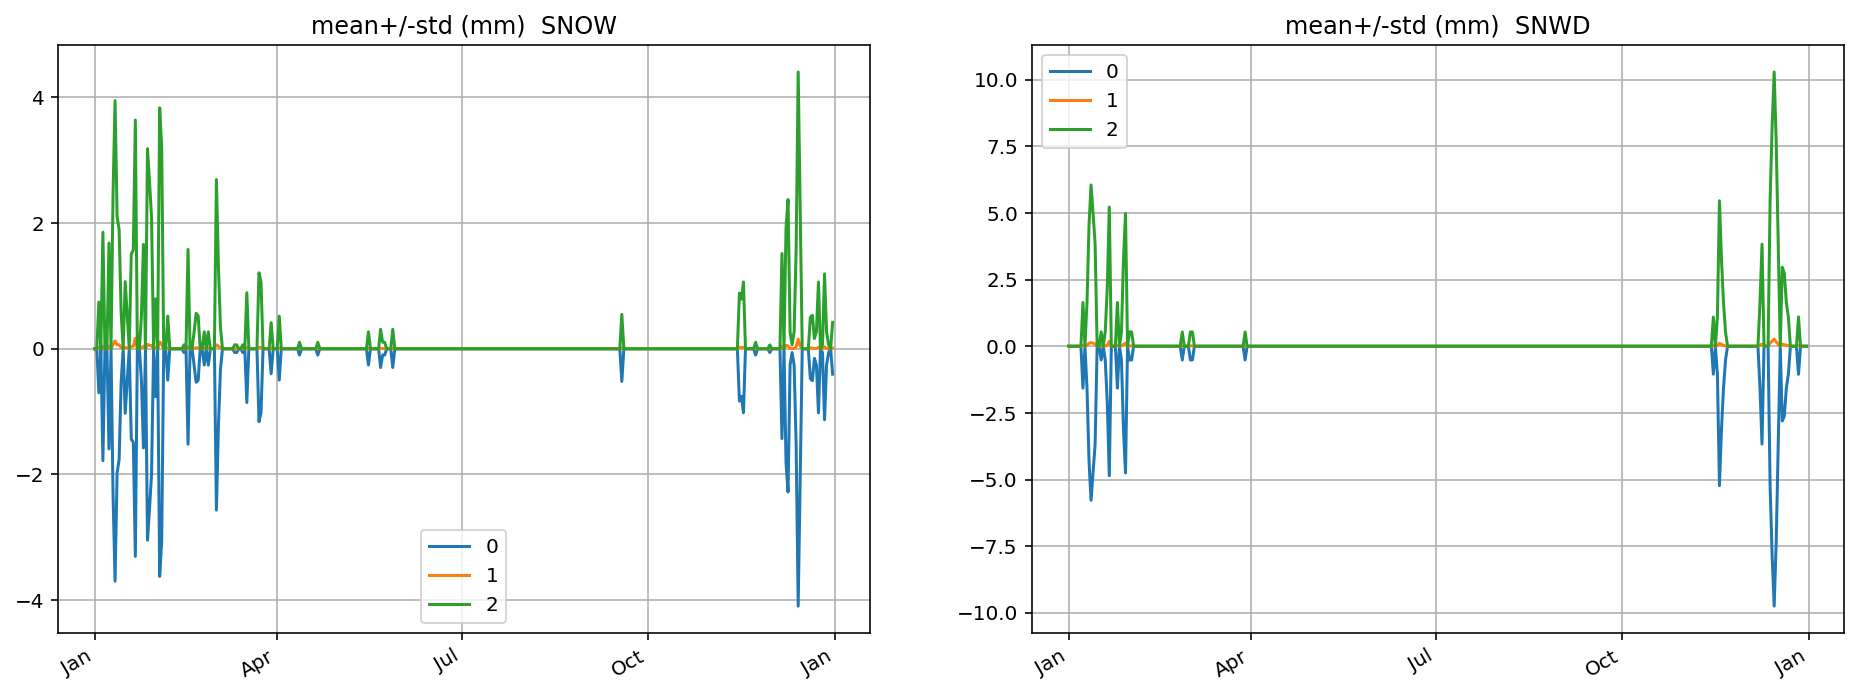

In [135]:
plot_pair(['SNOW','SNWD'],plot_mean_std_snow_snwd)

In [128]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='mean+/-std   '+m)

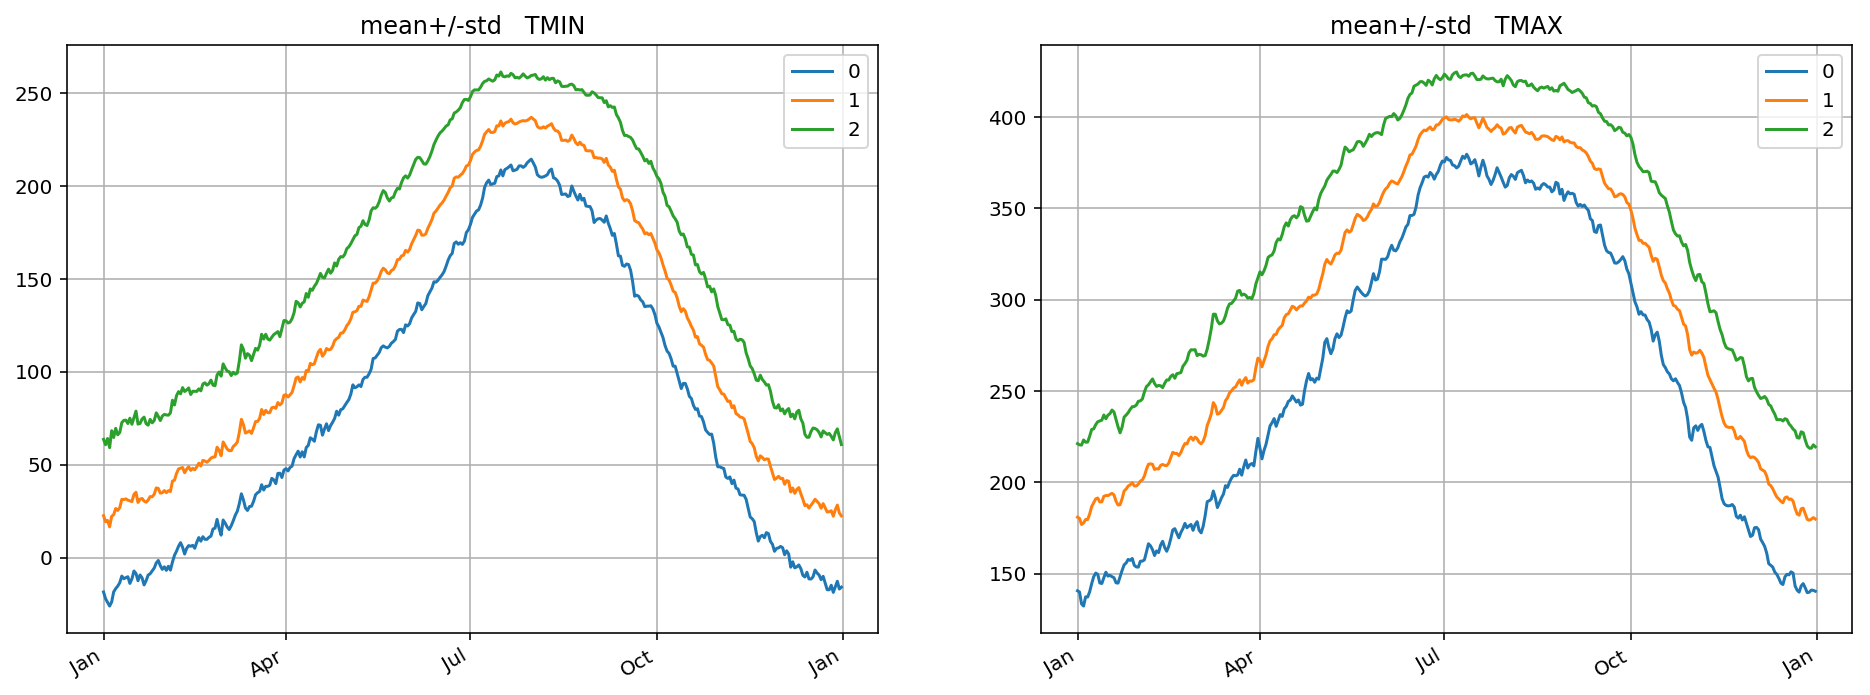

In [129]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

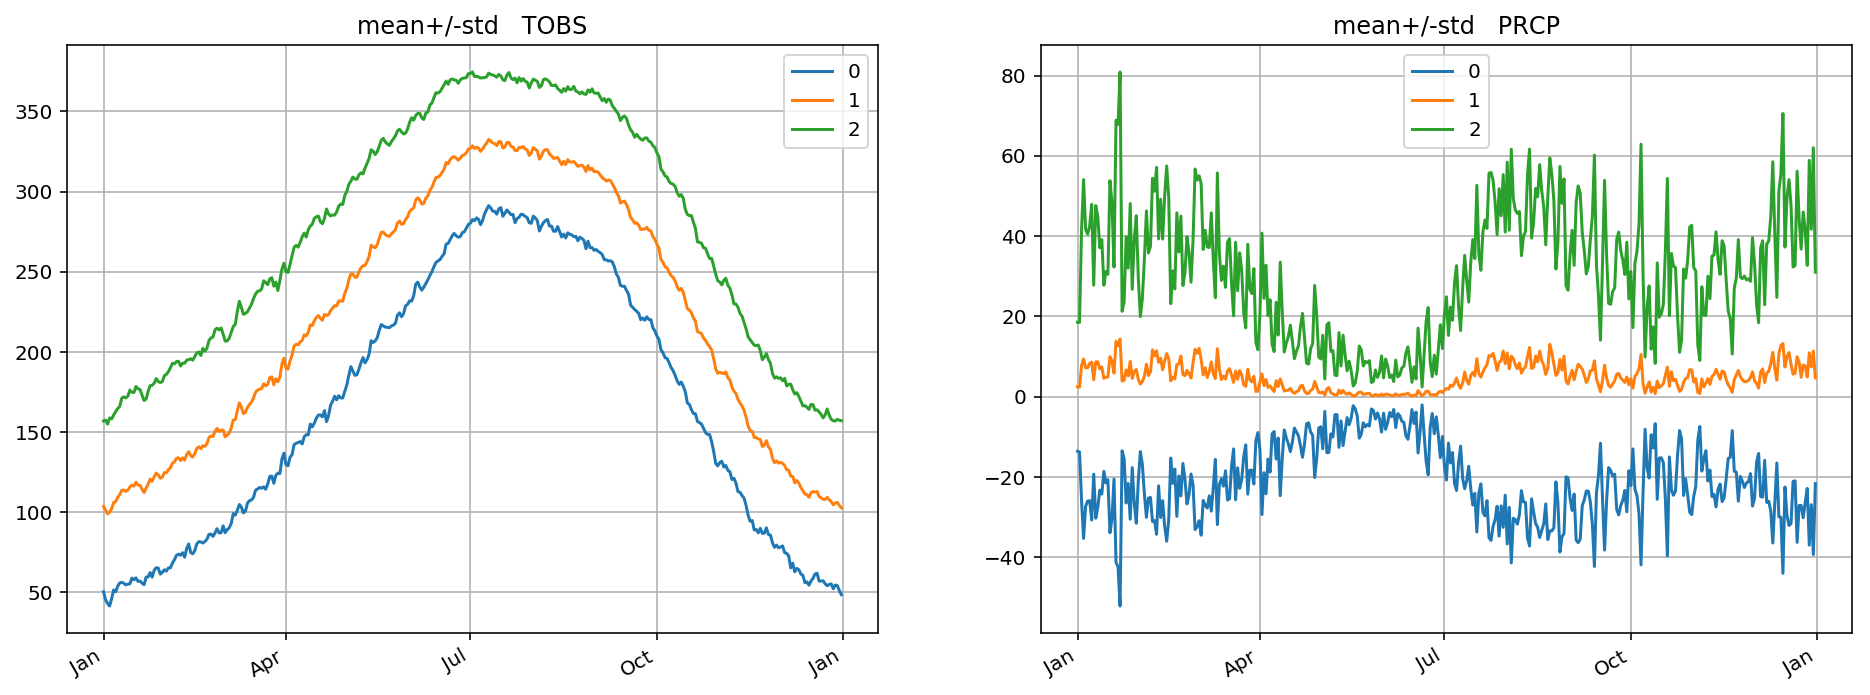

In [130]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

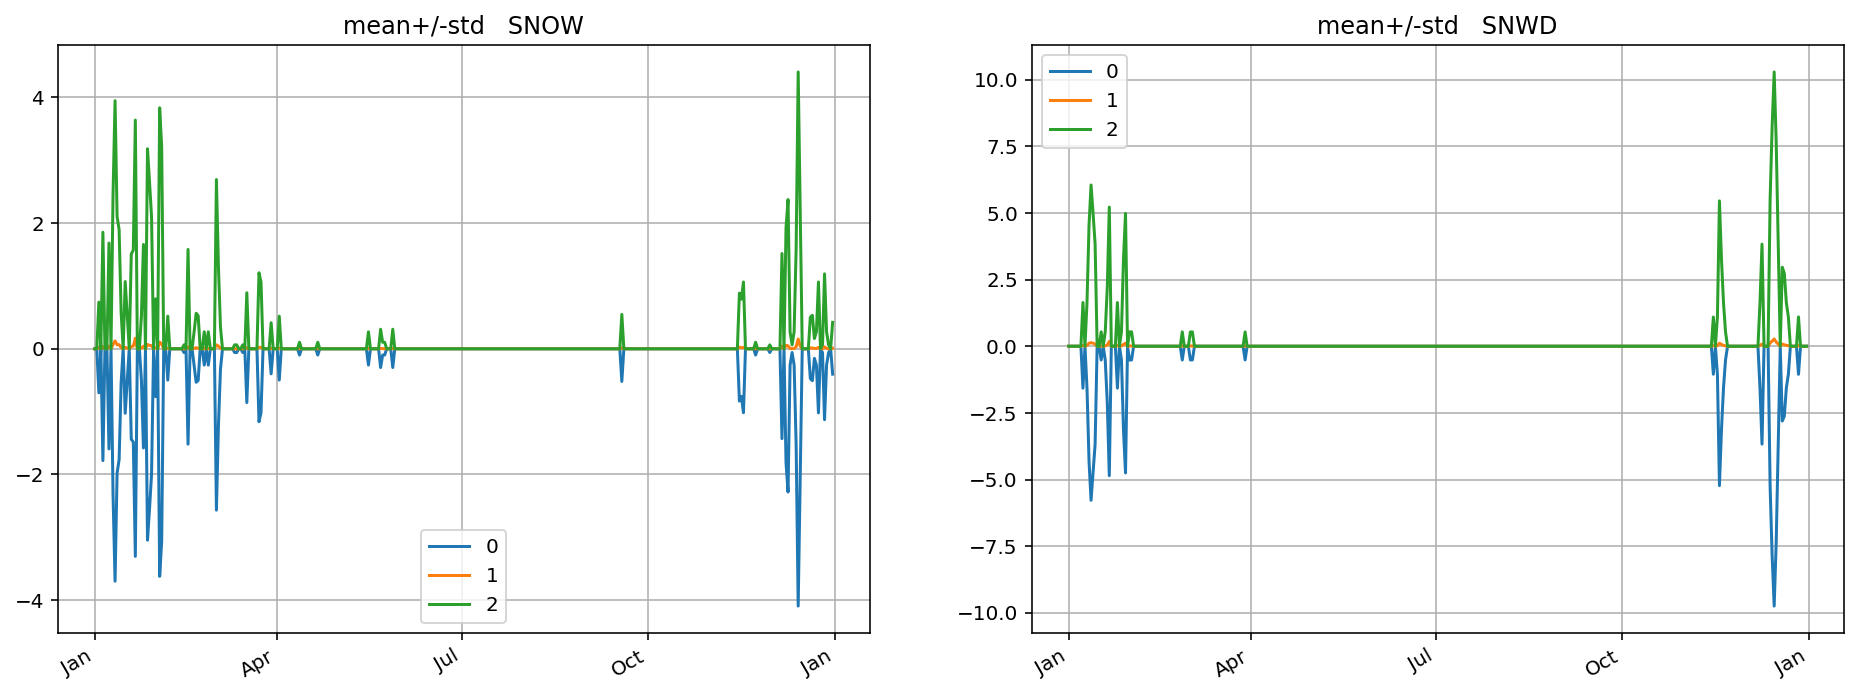

In [131]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [110]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

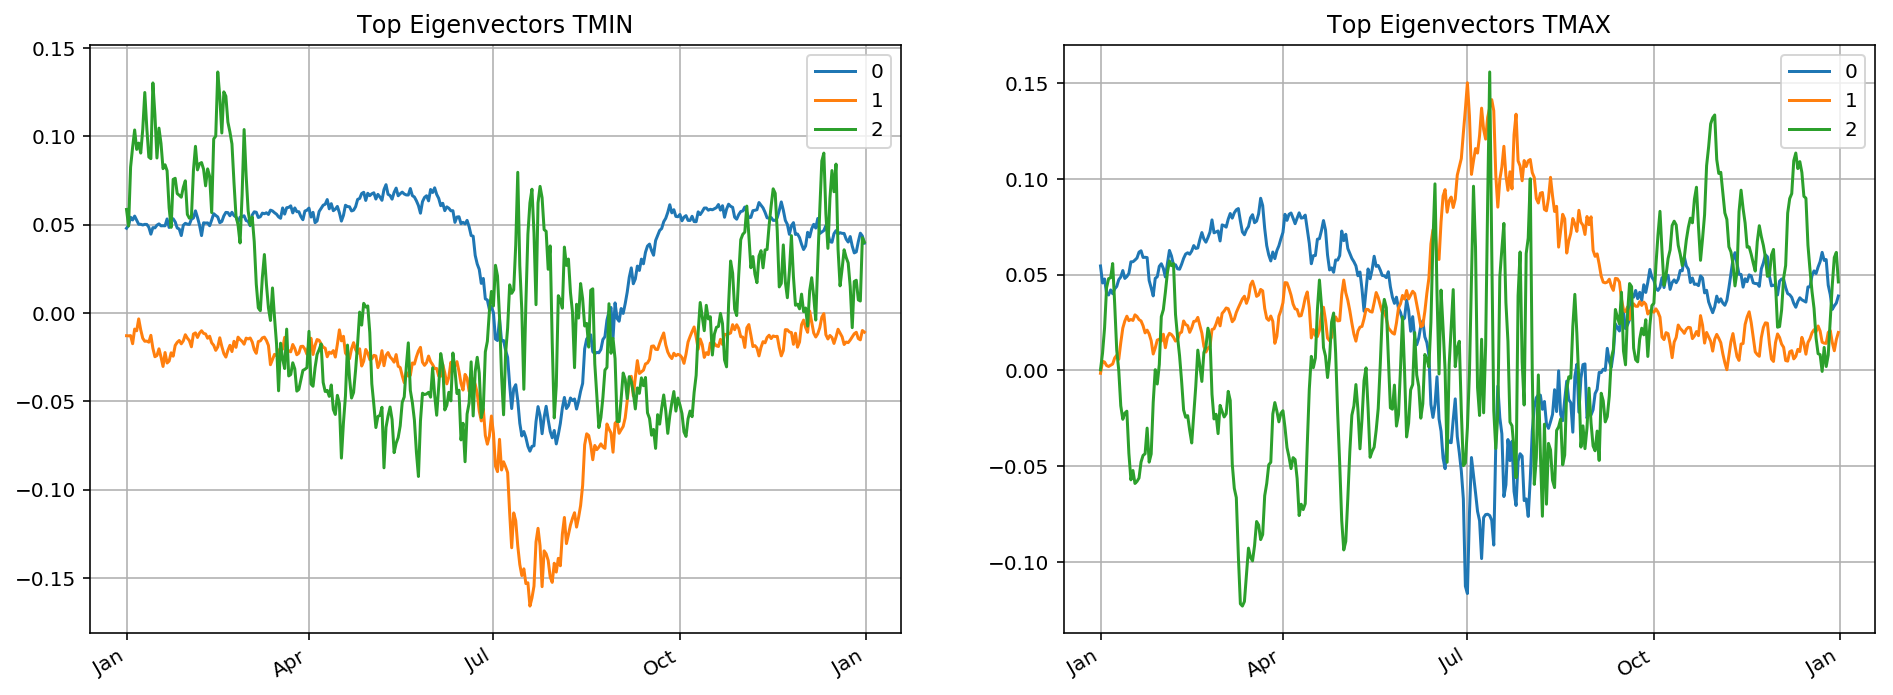

In [111]:
plot_pair(['TMIN','TMAX'],plot_eigen)

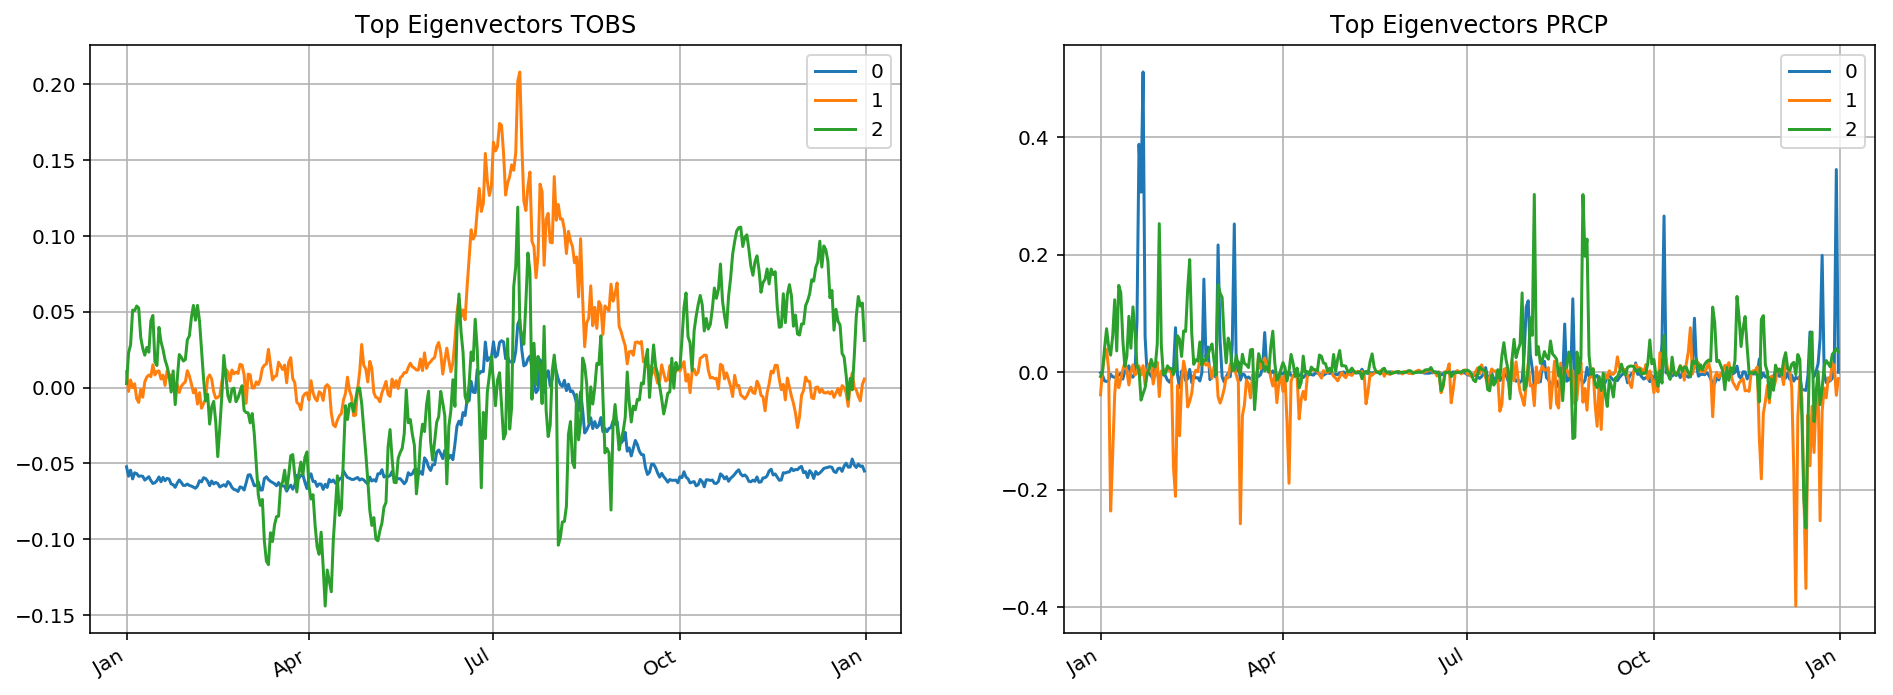

In [112]:
plot_pair(['TOBS','PRCP'],plot_eigen)

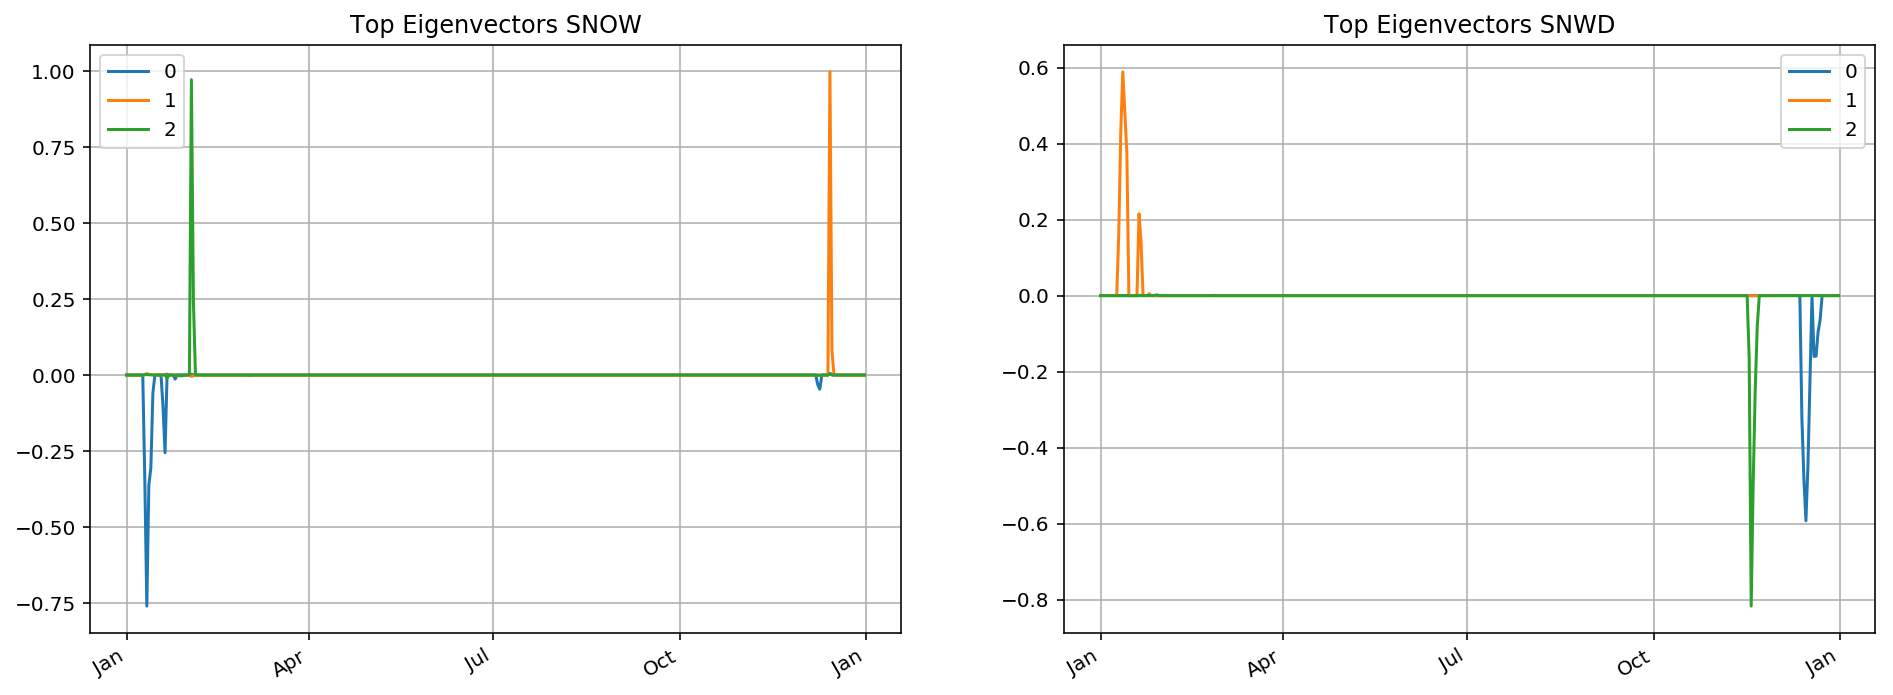

In [113]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [150]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=100
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

In [151]:
STAT['TMAX']['eigval']

array([  9.26578788e+04,  -9.53123394e+04,   3.52384572e+04,
         3.12911619e+04,  -2.13535646e+04,   2.75627297e+04,
        -1.85206315e+04,  -1.87878147e+04,   2.55824248e+04,
         2.31473635e+04,   2.21951425e+04,   2.19704230e+04,
         2.05008483e+04,   2.00379809e+04,   1.94969158e+04,
         1.83519043e+04,   1.76140108e+04,   1.65140536e+04,
        -1.37787956e+04,  -1.27413156e+04,  -1.21572837e+04,
        -1.07254843e+04,   1.61132569e+04,   1.53082602e+04,
        -9.06450883e+03,  -8.91527792e+03,   1.37872095e+04,
        -8.20631746e+03,   1.33901321e+04,   1.30580268e+04,
        -7.29304511e+03,  -7.03222157e+03,   1.26466651e+04,
         1.21006433e+04,   1.16719057e+04,  -6.17629700e+03,
         1.10996423e+04,   1.08305016e+04,   1.02731619e+04,
         9.80317975e+03,   9.33415827e+03,   8.87700576e+03,
         8.60870560e+03,   8.41178181e+03,   8.02373217e+03,
         7.92248939e+03,   7.57526318e+03,   7.01135042e+03,
        -5.51982638e+03,

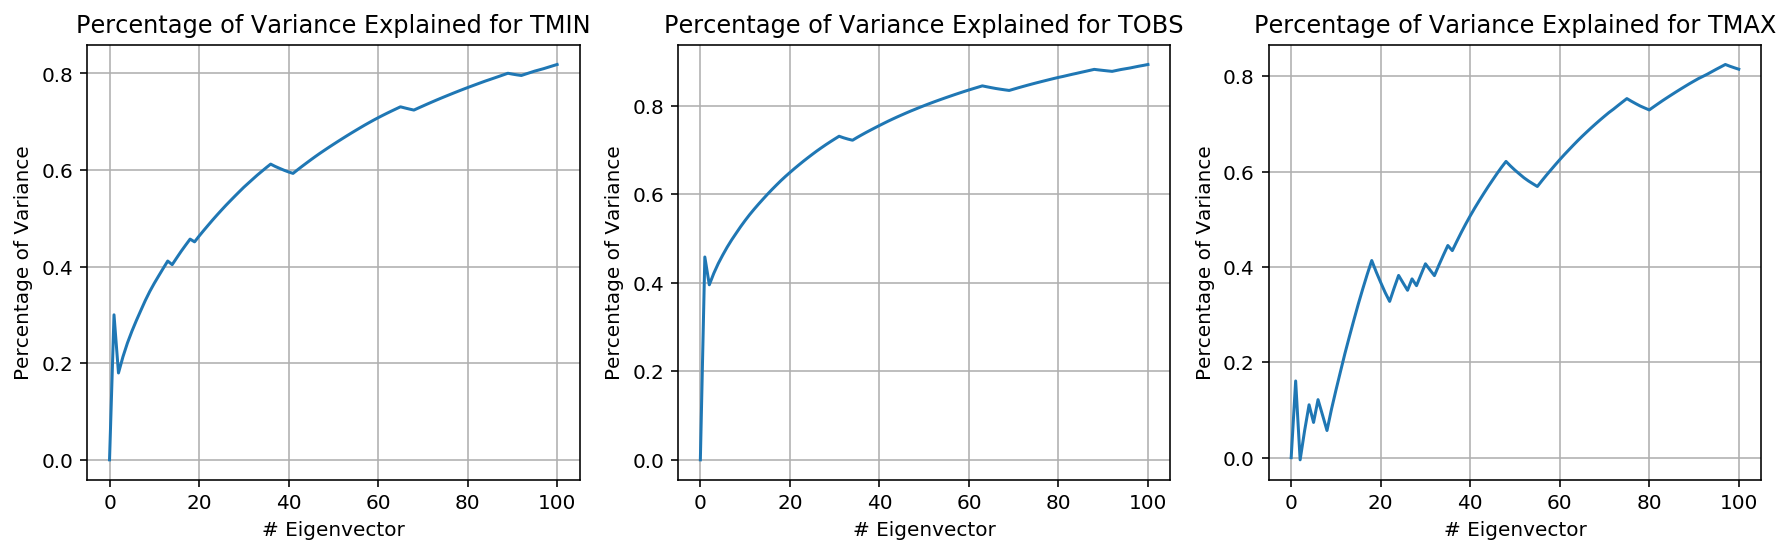

In [152]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN','TOBS','TMAX']: #,
    pltVarExplained(j)
    j+=1

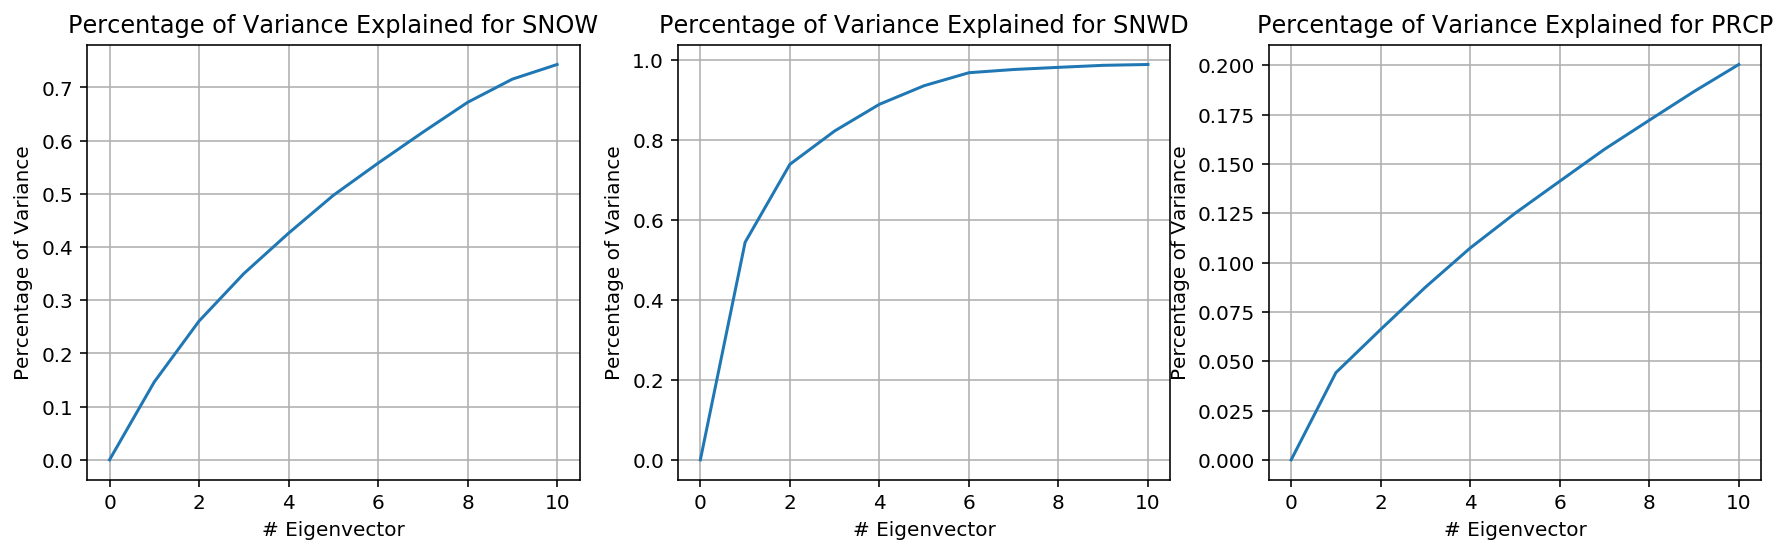

In [148]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [140]:
#sc.stop()